In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_82859/2969157509.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

/tmp/ipykernel_82859/649372525.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
/tmp/ipykernel_82859/649372525.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [3]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,1
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,5,0
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,6,1
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,6,1
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,5,0


# Re-organize the data: train/test in DataLoaders

In [4]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# Now for the DL part

In [6]:
# Create a class for the model
class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### Input layer
    self.input = nn.Linear(11, 16)
    # Define the input layer as a linear (fully connected) layer.
    # It takes input with 11 features and produces output with 16 units (neurons).

    ### Hidden layers
    self.fc1 = nn.Linear(16, 32)
    # Define the first hidden layer as a linear layer.
    # It takes input from the previous layer with 16 units and produces output with 32 units.

    self.fc2 = nn.Linear(32, 32)
    # Define the second hidden layer as another linear layer.
    # It takes input with 32 units and produces output with 32 units.

    ### Output layer
    self.output = nn.Linear(32, 1)
    # Define the output layer as a linear layer.
    # It takes input from the last hidden layer with 32 units and produces a single output (1 unit).
  
  # Forward pass
  def forward(self, x):
    x = F.relu(self.input(x))
    # Pass the input data 'x' through the input layer and apply the ReLU activation function.

    x = F.relu(self.fc1(x))
    # Pass the data through the first hidden layer and apply ReLU activation.

    x = F.relu(self.fc2(x))
    # Pass the data through the second hidden layer and apply ReLU activation.

    return self.output(x)
    # Pass the data through the output layer and return the network's output.


# Train the model

In [7]:
# A function that trains the model

# Global parameter
numepochs = 500  # Number of training epochs

def trainTheModel():

  # Loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with Logits
  optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)  # Stochastic Gradient Descent (SGD) optimizer

  # Initialize lists to store training statistics
  losses = torch.zeros(numepochs)  # To store losses at each epoch
  trainAcc = []  # To store training accuracies
  testAcc = []   # To store test accuracies

  # Loop over epochs
  for epochi in range(numepochs):

    # Switch on training mode for the neural network
    winenet.train()

    # Initialize lists to store batch-wise training statistics
    batchAcc = []    # To store batch accuracies
    batchLoss = []   # To store batch losses

    # Loop over training data batches
    for X, y in train_loader:

      # Forward pass and compute loss
      yHat = winenet(X)  # Forward pass to get predictions
      loss = lossfun(yHat, y)  # Compute the loss between predictions and actual labels

      # Backpropagation
      optimizer.zero_grad()  # Zero out gradients
      loss.backward()        # Backpropagate the loss
      optimizer.step()       # Update model parameters using the optimizer

      # Store the loss from this batch
      batchLoss.append(loss.item())

      # Compute training accuracy for this batch
      batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
    # End of batch loop...

    # Calculate the average training accuracy for this epoch
    trainAcc.append(np.mean(batchAcc))

    # Calculate the average loss across the batches for this epoch
    losses[epochi] = np.mean(batchLoss)

    # Test accuracy
    winenet.eval()  # Switch to evaluation mode (no gradient computation)
    X, y = next(iter(test_loader))  # Extract X, y from the test dataloader
    with torch.no_grad():  # Deactivate autograd (no gradient tracking)
      yHat = winenet(X)  # Forward pass to get test predictions
    testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

  # Function output: Returns training accuracies, test accuracies, and losses
  return trainAcc, testAcc, losses


# Now for the experiment

In [8]:
# This cell performs experiments to analyze the effect of different batch sizes on model training.

# Range of batch sizes
batchsizes = 2 ** np.arange(1, 10, 2)
# Create an array of batch sizes, starting from 2 and doubling with each step, up to 512.

# Initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest = np.zeros((numepochs, len(batchsizes)))
comptime = np.zeros(len(batchsizes))
# Create empty matrices to store training and testing accuracies, as well as computation times.

# Test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])
# Create a DataLoader for the test data. It has a batch size equal to the total number of samples in the test dataset.

# Loop over different batch sizes
for bi in range(len(batchsizes)):

  # Start the timer to measure computation time
  starttime = time.process_time()

  # Create DataLoader object for training data with the current batch size
  train_loader = DataLoader(train_dataDataset,
                            batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)
  # Create a DataLoader for training data with the current batch size.
  # - 'int(batchsizes[bi])': Converts the current batch size to an integer.
  # - 'shuffle=True': Shuffles the training data.
  # - 'drop_last=True': Drops the last batch if it's smaller than the specified batch size.

  # Create and train a model
  winenet = ANNwine()  # Create an instance of the neural network model
  trainAcc, testAcc, losses = trainTheModel()  # Train the model and obtain training statistics

  # Store training and testing accuracy results
  accuracyResultsTrain[:, bi] = trainAcc
  accuracyResultsTest[:, bi] = testAcc

  # Record the computation time
  comptime[bi] = time.process_time() - starttime


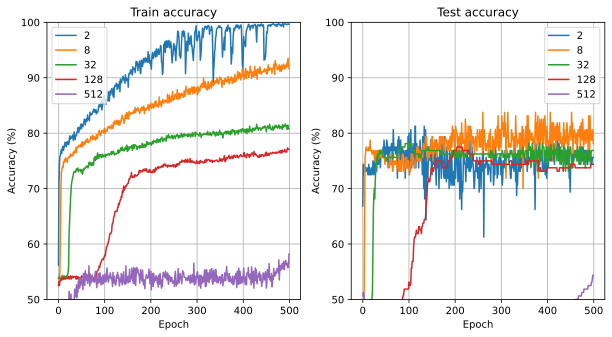

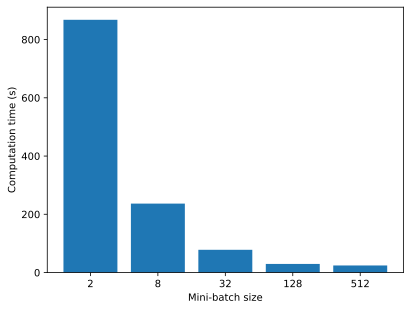

In [9]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()



# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()

### Reflections:
1. Small batch size takes longer to compute but will achieve higher accuracy because the model can learn more from each sample. Too large batch size will decrease convergence speed but will take enough longer epoches, it will eventually converge. 

# Additional explorations